In [1]:
import pandas as pd

# Import sheet with staffing and spending data

In [2]:
fiscdf = pd.read_csv("output/staffing-with-fiscal.csv")#.set_index(["City","report_year"])
fiscdf.head()

,City,report_year,index,Assignment Category,Educator Type,FTE Count,OrganizationCode,OrganizationType,Education spending,Enrollment
0,NEW HAVEN,2009,Achievement First Hartford Academy Inc. District,Administrators Coordinators and Department Ch...,Certified,6.0,2880013,Public Charter School Districts,192024547.0,18074.31
1,NEW HAVEN,2009,Achievement First Hartford Academy Inc. District,General Education - Teachers and Instructors,Certified,20.0,2880013,Public Charter School Districts,192024547.0,18074.31
2,NEW HAVEN,2009,Achievement First Hartford Academy Inc. District,General Education - Paraprofessional Instructi...,Non-Certified,0.0,2880013,Public Charter School Districts,192024547.0,18074.31
3,NEW HAVEN,2009,Achievement First Hartford Academy Inc. District,Library/Media - Support Staff,Non-Certified,0.0,2880013,Public Charter School Districts,192024547.0,18074.31
4,NEW HAVEN,2009,Achievement First Hartford Academy Inc. District,School Nurses,Non-Certified,0.5,2880013,Public Charter School Districts,192024547.0,18074.31


# Limit it to just public school districts

In [3]:
pubs = fiscdf[fiscdf["OrganizationType"] == "Public School Districts"]
pubs.head()

,City,report_year,index,Assignment Category,Educator Type,FTE Count,OrganizationCode,OrganizationType,Education spending,Enrollment
39,NEW HAVEN,2009,New Haven School District,Administrators Coordinators and Department Ch...,Certified,115.2,930011,Public School Districts,192024547.0,18074.31
40,NEW HAVEN,2009,New Haven School District,General Education - Teachers and Instructors,Certified,1284.2,930011,Public School Districts,192024547.0,18074.31
41,NEW HAVEN,2009,New Haven School District,General Education - Paraprofessional Instructi...,Non-Certified,236.0,930011,Public School Districts,192024547.0,18074.31
42,NEW HAVEN,2009,New Haven School District,Library/Media - Support Staff,Non-Certified,1.0,930011,Public School Districts,192024547.0,18074.31
43,NEW HAVEN,2009,New Haven School District,School Nurses,Non-Certified,30.3,930011,Public School Districts,192024547.0,18074.31


# Check for cities with more than one school distrct

Since there's only two, and they're small, they might not come up at all.

In [4]:
# Let's make sure there are no cities with more than one public school district.
# even though some cities, like hartford, are home to other districts, which has
# Hartfored Achievement, but also Hartford Public
import numpy as np
pubs.groupby("City").agg({"index":pd.Series.nunique}).sort_values(by="index",ascending=False).head()

,index
City,
DEEP RIVER,3
EASTON,2
ANDOVER,1
SIMSBURY,1
SHELTON,1


In [5]:
pubs[pubs["City"] == "DEEP RIVER"]["index"].unique()

array(['Chester School District', 'Deep River School District',
       'Essex School District'], dtype=object)

In [6]:
pubs[pubs["City"] == "EASTON"]["index"].unique()

array(['Easton School District', 'Redding School District'], dtype=object)

# Aggregate the FTE count

Problem: Some years have missing data. Some of the data is null because its zero, but some is null because of a mistake. BRANFORD, for instance, dropped a ton of FTEs in FY 16 because their parapofessional line went from 150-ish to N/A.

One solution is to drop EVERY line where ANY of the values are null, but that is extreme because many of the nulls are valid.

The better solution is to do that, but for only categories where the district had that type of employee the previous year.

In [7]:
# # Here's where we can see the holes
def spot_holes(city):
    tmpdf = pubs[pubs["City"] == city.upper()]
    tmpdf = pd.pivot_table(
        tmpdf,
        columns="Assignment Category",
        values="FTE Count",
        index=["City","report_year"]
   )
    
    # Drop columns that are all empty
    tmpdf = tmpdf.dropna(axis=1,how="all")
    
    # Drop rows that have any nulls
    tmpdf = tmpdf.dropna(axis=0,how="any")
    
    valid_indexes = tmpdf.index
    
    return valid_indexes

spot_holes("Branford")

MultiIndex(levels=[[u'BRANFORD'], [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 4, 5, 6, 7, 8]],
           names=[u'City', u'report_year'])

In [8]:
fisc_totals = pubs.groupby(["City","report_year"]).agg({
    "Education spending":max,
    "Enrollment": max,
    "FTE Count": sum
})

fisc_totals.head()

Enrollment  FTE Count  Education spending
City    report_year                                           
ANDOVER 2007             645.40       60.9           7507964.0
        2008             642.14       58.0           8829049.0
        2009             641.76       59.4           8056856.0
        2010             631.35       60.0           7844581.0
        2011             636.48       59.7           8009858.0

# Add in state grant levels

For now we're going to use just ECS

In [9]:
grantsdf = pd.read_csv("output/grants-by-town-year.csv")
#grantsdf = pd.read_csv("output/ecs-by-town-year.csv") # Trying to clean it up by JUST using ECS

grantsdf["City"] = grantsdf["VName"].apply(lambda x: x.strip().upper())
grantsdf["report_year"] = grantsdf["FYEAR"]
grantsdf = grantsdf.set_index(["City","report_year"])
grantsdf.head(15)

VName  FYEAR      Payment
City    report_year                             
ANSONIA 2004         Ansonia   2004  15719237.99
        2005         Ansonia   2005  17815777.31
        2006         Ansonia   2006  18317458.27
        2007         Ansonia   2007  19015633.54
        2008         Ansonia   2008  20755734.21
        2009         Ansonia   2009  21034180.89
        2010         Ansonia   2010  21796853.32
        2011         Ansonia   2011  22181436.60
        2012         Ansonia   2012  21955987.39
        2013         Ansonia   2013  21488258.20
        2014         Ansonia   2014  22007731.82
        2015         Ansonia   2015  22245689.95
        2016         Ansonia   2016  22883103.31
        2017         Ansonia   2017  22849402.08
        2018         Ansonia   2018  22866629.56

In [10]:
# trim years

In [11]:
combined = grantsdf.join(fisc_totals)
combined = combined[combined["FYEAR"].apply(lambda x: x in range(2005,2017))]
combined.head(15)

VName  FYEAR      Payment  Enrollment  FTE Count  \
City    report_year                                                       
ANSONIA 2005         Ansonia   2005  17815777.31         NaN        NaN   
        2006         Ansonia   2006  18317458.27         NaN        NaN   
        2007         Ansonia   2007  19015633.54     2831.14      489.8   
        2008         Ansonia   2008  20755734.21     2867.43      391.9   
        2009         Ansonia   2009  21034180.89     2854.78      404.5   
        2010         Ansonia   2010  21796853.32     2867.97      373.2   
        2011         Ansonia   2011  22181436.60     2795.42      399.6   
        2012         Ansonia   2012  21955987.39     2710.56      389.6   
        2013         Ansonia   2013  21488258.20     2628.64      376.7   
        2014         Ansonia   2014  22007731.82     2528.60      391.7   
        2015         Ansonia   2015  22245689.95     2585.10      347.2   
        2016         Ansonia   2016  22883103.31     2524.46      353.5   
AVON    2005            Avon   2005   1874596.56         NaN        NaN   
        2006            Avon   2006   2135340.34         NaN        NaN   
        2007            Avon   2007   2256197.16     3511.67      458.6   

                     Education spending  
City    report_year                      
ANSONIA 2005                        NaN  
        2006                        NaN  
        2007                 29660930.0  
        2008                 38418010.0  
        2009                 31520992.0  
        2010                 32282747.0  
        2011                 31895845.0  
        2012                 33764768.0  
        2013                 34124712.0  
        2014                 35784832.0  
        2015                 37029834.0  
        2016                 38507977.0  
AVON    2005                        NaN  
        2006                        NaN  
        2007                 38966040.0

In [12]:
# Adjust payment as pct of the budget
combined["payment_pct"] = combined["Payment"] / combined["Education spending"]

In [13]:
# Adjust FTE (employment), spending (budget), and payment per enrollment
combined["fte_per_student"] = combined["FTE Count"]/combined["Enrollment"]
combined["spending_per_student"] = combined["Education spending"]/combined["Enrollment"]
combined["payment_per_student"] = combined["Payment"]/combined["Enrollment"]

In [14]:
combined.head()

VName  FYEAR      Payment  Enrollment  FTE Count  \
City    report_year                                                       
ANSONIA 2005         Ansonia   2005  17815777.31         NaN        NaN   
        2006         Ansonia   2006  18317458.27         NaN        NaN   
        2007         Ansonia   2007  19015633.54     2831.14      489.8   
        2008         Ansonia   2008  20755734.21     2867.43      391.9   
        2009         Ansonia   2009  21034180.89     2854.78      404.5   

                     Education spending  payment_pct  fte_per_student  \
City    report_year                                                     
ANSONIA 2005                        NaN          NaN              NaN   
        2006                        NaN          NaN              NaN   
        2007                 29660930.0     0.641100         0.173005   
        2008                 38418010.0     0.540261         0.136673   
        2009                 31520992.0     0.667307         0.141692   

                     spending_per_student  payment_per_student  
City    report_year                                             
ANSONIA 2005                          NaN                  NaN  
        2006                          NaN                  NaN  
        2007                 10476.673707          6716.599511  
        2008                 13398.063771          7238.444952  
        2009                 11041.478503          7368.056694

In [15]:
combined.sort_values(by="fte_per_student",ascending=False).head()

,,VName,FYEAR,Payment,Enrollment,FTE Count,Education spending,payment_pct,fte_per_student,spending_per_student,payment_per_student
City,report_year,,,,,,,,,,
STERLING,2013,Sterling,2013,3823158.88,664.02,178.1,8274645.0,0.462033,0.268215,12461.439414,5757.595976
WESTBROOK,2016,Westbrook,2016,819661.60,782.98,190.1,19167229.0,0.042764,0.242790,24479.844951,1046.848706
WINDSOR LOCKS,2016,Windsor Locks,2016,7737137.47,1703.28,396.8,33117510.0,0.233627,0.232962,19443.373961,4542.492996
STERLING,2015,Sterling,2015,3949978.88,607.06,140.2,8378283.0,0.471454,0.230949,13801.408428,6506.735545
WESTBROOK,2015,Westbrook,2015,805348.41,817.96,187.1,17767390.0,0.045327,0.228740,21721.587853,984.581654


## Any correlations?

In [16]:
combined.corr()

,FYEAR,Payment,Enrollment,FTE Count,Education spending,payment_pct,fte_per_student,spending_per_student,payment_per_student
FYEAR,1.000000,0.050590,-0.023014,0.009204,0.062660,0.016425,0.271272,0.554607,0.144264
Payment,0.050590,1.000000,0.835118,0.834362,0.747151,0.743398,-0.060548,-0.266593,0.696720
Enrollment,-0.023014,0.835118,1.000000,0.983937,0.961922,0.455658,-0.095916,-0.226780,0.370828
FTE Count,0.009204,0.834362,0.983937,1.000000,0.954261,0.439747,0.020847,-0.176099,0.361266
Education spending,0.062660,0.747151,0.961922,0.954261,1.000000,0.305608,-0.036272,-0.031910,0.265816
payment_pct,0.016425,0.743398,0.455658,0.439747,0.305608,1.000000,-0.150312,-0.461643,0.961191
fte_per_student,0.271272,-0.060548,-0.095916,0.020847,-0.036272,-0.150312,1.000000,0.446493,-0.071916
spending_per_student,0.554607,-0.266593,-0.226780,-0.176099,-0.031910,-0.461643,0.446493,1.000000,-0.277445
payment_per_student,0.144264,0.696720,0.370828,0.361266,0.265816,0.961191,-0.071916,-0.277445,1.000000


## Questions

1. When spending went down, did FTE count / enrollment go down?
2. Did districts 

In [17]:
print combined["payment_pct"].median()
combined["payment_pct"].describe()

0.27373929982750533


count    1060.000000
mean        0.318285
std         0.235279
min         0.031163
25%         0.142623
50%         0.273739
75%         0.433112
max         1.361659
Name: payment_pct, dtype: float64

In [18]:
print "Most grant-dependent districts 2014"
combined[combined["FYEAR"]== 2014].sort_values(by="payment_pct",ascending=False).head()

Most grant-dependent districts 2014


,,VName,FYEAR,Payment,Enrollment,FTE Count,Education spending,payment_pct,fte_per_student,spending_per_student,payment_per_student
City,report_year,,,,,,,,,,
NEW HAVEN,2014,New Haven,2014,2.715365e+08,18738.35,4053.4,210739315.0,1.288495,0.216316,11246.417908,14490.948430
HARTFORD,2014,Hartford,2014,3.395887e+08,21784.34,3369.0,321535000.0,1.056149,0.154652,14759.914691,15588.663124
WATERBURY,2014,Waterbury,2014,1.875164e+08,17970.40,2876.2,180634000.0,1.038101,0.160052,10051.751770,10434.737572
BRIDGEPORT,2014,Bridgeport,2014,2.657530e+08,21008.02,2864.0,267927607.0,0.991884,0.136329,12753.586821,12650.073620
NEW LONDON,2014,New London,2014,4.224478e+07,3532.73,473.8,45031924.0,0.938107,0.134117,12747.060772,11958.111690


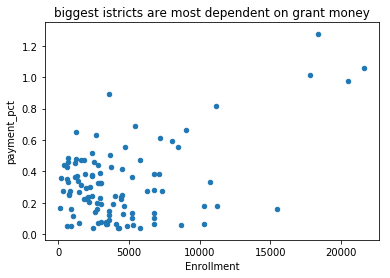

In [19]:
%matplotlib inline
combined["Enrollment"] = pd.to_numeric(combined["Enrollment"])
combined[combined["FYEAR"] == 2013].plot.scatter(
    x="Enrollment",
    y="payment_pct",
    title="biggest istricts are most dependent on grant money"
)

## Time to add annual change columns


In [20]:
combined.head()

VName  FYEAR      Payment  Enrollment  FTE Count  \
City    report_year                                                       
ANSONIA 2005         Ansonia   2005  17815777.31         NaN        NaN   
        2006         Ansonia   2006  18317458.27         NaN        NaN   
        2007         Ansonia   2007  19015633.54     2831.14      489.8   
        2008         Ansonia   2008  20755734.21     2867.43      391.9   
        2009         Ansonia   2009  21034180.89     2854.78      404.5   

                     Education spending  payment_pct  fte_per_student  \
City    report_year                                                     
ANSONIA 2005                        NaN          NaN              NaN   
        2006                        NaN          NaN              NaN   
        2007                 29660930.0     0.641100         0.173005   
        2008                 38418010.0     0.540261         0.136673   
        2009                 31520992.0     0.667307         0.141692   

                     spending_per_student  payment_per_student  
City    report_year                                             
ANSONIA 2005                          NaN                  NaN  
        2006                          NaN                  NaN  
        2007                 10476.673707          6716.599511  
        2008                 13398.063771          7238.444952  
        2009                 11041.478503          7368.056694

In [21]:
def add_change_cols():
    
    staffing_change = []
    
    payment_change_dollars = []
    payment_change = []
    payment_change2 = []
    
    staffing_change_per_student = []
    payment_change_per_student = []
    
    for i, row in combined.iterrows():
        year = i[1]
        city = i[0]
        
        try:
            last_year = combined.loc[city,year-1]
            year_before_last = combined.loc[city,year-2]
        except Exception as e:
            #print "E:" + str(e)
            staffing_change.append(None)
            payment_change.append(None)
            payment_change2.append(None)
            payment_change_dollars.append(None)

            staffing_change_per_student.append(None)
            payment_change_per_student.append(None)
            continue
        #print "OK"
        
#         staffing_change_per_student.append(row["FTE_per_student"] - last_year["FTE_per_student"])
#         payment_change_per_student.append(row["Payment_per_student"] - year_before_last["Payment_per_student"])
        
        staffing_change.append((row["FTE Count"] - last_year["FTE Count"]) / last_year["FTE Count"])
        payment_change.append((row["Payment"] - last_year["Payment"]) / last_year["Payment"])
#         payment_change2.append((row["Payment"] - year_before_last["Payment"]) / year_before_last["Payment"])
        payment_change_dollars.append(row["Payment"] - last_year["Payment"])
    
    ret = combined.copy()
    
    ret["staffing_change_pct"] = staffing_change
    ret["payment_change_dollars"] = payment_change_dollars
    ret["payment_change_pct"] = payment_change
    #ret["payment_change_pct2"] = payment_change2


    
#     ret["staffing_change_per_student"] = staffing_change_per_student
#     ret["payment_change_per_student"] = payment_change_per_student


    print len(staffing_change)
    print len(payment_change)
    print len(combined)
    
    return ret

combined_with_changes = add_change_cols()
combined_with_changes.head()

1464
1464
1464


VName  FYEAR      Payment  Enrollment  FTE Count  \
City    report_year                                                       
ANSONIA 2005         Ansonia   2005  17815777.31         NaN        NaN   
        2006         Ansonia   2006  18317458.27         NaN        NaN   
        2007         Ansonia   2007  19015633.54     2831.14      489.8   
        2008         Ansonia   2008  20755734.21     2867.43      391.9   
        2009         Ansonia   2009  21034180.89     2854.78      404.5   

                     Education spending  payment_pct  fte_per_student  \
City    report_year                                                     
ANSONIA 2005                        NaN          NaN              NaN   
        2006                        NaN          NaN              NaN   
        2007                 29660930.0     0.641100         0.173005   
        2008                 38418010.0     0.540261         0.136673   
        2009                 31520992.0     0.667307         0.141692   

                     spending_per_student  payment_per_student  \
City    report_year                                              
ANSONIA 2005                          NaN                  NaN   
        2006                          NaN                  NaN   
        2007                 10476.673707          6716.599511   
        2008                 13398.063771          7238.444952   
        2009                 11041.478503          7368.056694   

                     staffing_change_pct  payment_change_dollars  \
City    report_year                                                
ANSONIA 2005                         NaN                     NaN   
        2006                         NaN                     NaN   
        2007                         NaN               698175.27   
        2008                   -0.199878              1740100.67   
        2009                    0.032151               278446.68   

                     payment_change_pct  
City    report_year                      
ANSONIA 2005                        NaN  
        2006                        NaN  
        2007                   0.038115  
        2008                   0.091509  
        2009                   0.013415

In [22]:
## Are there any ridiculously big staffing changes?
# the biggest cut is 57% -- yikes! The biggest increase is more than 100%,
# but the middle of the curve looks normal
combined_with_changes["staffing_change_pct"].describe()


count    954.000000
mean       0.005627
std        0.098016
min       -0.576506
25%       -0.019839
50%        0.001968
75%        0.022724
max        1.037757
Name: staffing_change_pct, dtype: float64

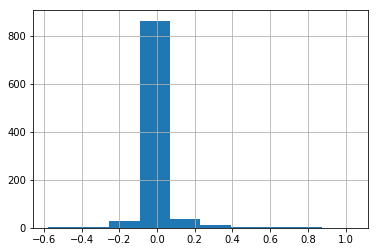

In [23]:
combined_with_changes["staffing_change_pct"].hist()


In [24]:
combined_with_changes.sort_values(by="staffing_change_pct",ascending=True).head()

,,VName,FYEAR,Payment,Enrollment,FTE Count,Education spending,payment_pct,fte_per_student,spending_per_student,payment_per_student,staffing_change_pct,payment_change_dollars,payment_change_pct
City,report_year,,,,,,,,,,,,,
BRANFORD,2016,Branford,2016,5128385.56,3121.52,296.7,59226125.0,0.086590,0.095050,18973.488877,1642.912927,-0.576506,148859.98,0.029894
BROOKLYN,2016,Brooklyn,2016,8496875.36,1225.40,76.1,17955158.0,0.473228,0.062102,14652.487351,6933.960633,-0.566875,235360.55,0.028489
STERLING,2014,Sterling,2014,3994169.42,632.70,86.6,8540868.0,0.467654,0.136874,13499.080133,6312.896191,-0.513756,171010.54,0.044730
EAST WINDSOR,2012,East Windsor,2012,7273611.34,1369.13,123.2,21503161.0,0.338258,0.089984,15705.711656,5312.579039,-0.453659,-318645.14,-0.041970
SOMERS,2010,Somers,2010,7287941.74,1634.39,145.3,19932606.0,0.365629,0.088902,12195.746425,4459.120369,-0.437693,152480.29,0.021369


In [25]:
# In Branford, staffing changed massively in 2016, but we can see in 
combined_with_changes.loc["BRANFORD"]

,VName,FYEAR,Payment,Enrollment,FTE Count,Education spending,payment_pct,fte_per_student,spending_per_student,payment_per_student,staffing_change_pct,payment_change_dollars,payment_change_pct
report_year,,,,,,,,,,,,,
2005,Branford,2005,3761818.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,Branford,2006,3827775.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,Branford,2007,3848652.72,3650.43,564.4,45013856.0,0.085499,0.154612,12331.110581,1054.301197,NaN,20876.86,0.005454
2008,Branford,2008,4452406.23,3536.50,568.3,60571587.0,0.073507,0.160696,17127.551817,1258.986634,0.006910,603753.51,0.156874
2009,Branford,2009,4722572.23,3536.87,578.8,49602424.0,0.095208,0.163648,14024.384272,1335.240546,0.018476,270166.00,0.060679
2010,Branford,2010,5717941.51,3581.27,583.0,50550551.0,0.113113,0.162791,14115.258274,1596.623966,0.007256,995369.28,0.210768
2011,Branford,2011,4290608.85,3488.31,565.8,52066037.0,0.082407,0.162199,14925.862954,1229.996431,-0.029503,-1427332.66,-0.249624
2012,Branford,2012,4831333.82,3393.42,567.6,54721423.0,0.088290,0.167265,16125.744234,1423.735883,0.003181,540724.97,0.126025
2013,Branford,2013,4483878.32,3353.78,572.3,56100841.0,0.079925,0.170643,16727.644926,1336.962568,0.008280,-347455.50,-0.071917


Assignment Category,Administrators Coordinators and Department Chairs - District Central Office,Administrators Coordinators and Department Chairs - School Level,Counselors Social Workers and School Psychologists,General Education - Paraprofessional Instructional Assistants,General Education - Teachers and Instructors,Instructional Specialists Who Support Teachers,Library/Media - Specialists (Certified),Library/Media - Support Staff,Other Staff Providing Non-Instructional Services/Support,School Nurses,Special Education - Paraprofessional Instructional Assistants,Special Education - Teachers and Instructors
report_year,,,,,,,,,,,,
2007,2.0,14.7,19.3,19.8,245.1,7.9,6.5,3.4,146.8,8.0,58.1,32.8
2008,3.0,15.0,20.3,13.2,249.0,8.3,7.0,1.1,154.9,8.0,55.0,33.5
2009,3.0,14.8,19.0,20.2,245.5,7.9,7.0,3.4,164.3,6.0,56.2,31.5
2010,4.0,13.8,18.4,25.8,242.9,8.9,6.5,3.9,161.0,6.0,61.3,30.5
2011,4.0,13.1,17.5,18.0,244.3,7.9,6.5,4.0,146.6,6.0,65.4,32.5
2012,4.0,13.2,17.5,24.7,234.9,7.5,6.0,4.0,147.6,6.0,68.7,33.5
2013,4.0,13.6,17.5,26.1,245.8,8.4,6.6,3.5,136.5,6.0,70.1,34.2
2014,6.0,13.6,17.0,118.0,237.5,8.5,6.0,5.0,138.0,6.0,82.0,33.0
2015,6.0,14.1,15.4,146.5,225.4,6.0,5.0,5.0,145.0,7.0,96.5,28.7


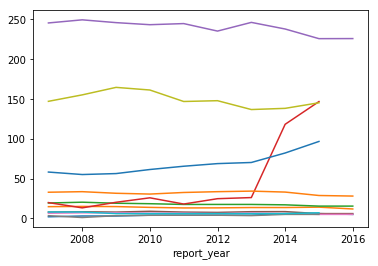

In [26]:
staffing = pd.read_csv("output/staffing-with-fiscal.csv").set_index("City","report_year")
def inspect_staffing(city):
    pd.pivot_table(staffing.loc[city],
                   index=("report_year"),
                   values="FTE Count",
                   columns="Assignment Category").plot(legend=False)
    return pd.pivot_table(staffing.loc[city],
                   index=("report_year"),
                   values="FTE Count",
                   columns="Assignment Category")
inspect_staffing("BRANFORD")
            

In [27]:
#inspect_staffing("BROOKLYN")

In [28]:
#inspect_staffing("STERLING")

In [29]:
combined_with_changes

VName  FYEAR      Payment  Enrollment  \
City          report_year                                                  
ANSONIA       2005               Ansonia   2005  17815777.31         NaN   
              2006               Ansonia   2006  18317458.27         NaN   
              2007               Ansonia   2007  19015633.54     2831.14   
              2008               Ansonia   2008  20755734.21     2867.43   
              2009               Ansonia   2009  21034180.89     2854.78   
              2010               Ansonia   2010  21796853.32     2867.97   
              2011               Ansonia   2011  22181436.60     2795.42   
              2012               Ansonia   2012  21955987.39     2710.56   
              2013               Ansonia   2013  21488258.20     2628.64   
              2014               Ansonia   2014  22007731.82     2528.60   
              2015               Ansonia   2015  22245689.95     2585.10   
              2016               Ansonia   2016  22883103.31     2524.46   
AVON          2005                  Avon   2005   1874596.56         NaN   
              2006                  Avon   2006   2135340.34         NaN   
              2007                  Avon   2007   2256197.16     3511.67   
              2008                  Avon   2008   2721874.42     3596.56   
              2009                  Avon   2009   2904506.12     3573.81   
              2010                  Avon   2010   3786164.49     3616.52   
              2011                  Avon   2011   3316628.96     3585.43   
              2012                  Avon   2012   3576824.47     3538.00   
              2013                  Avon   2013   3633484.04     3472.15   
              2014                  Avon   2014   4286031.27     3420.67   
              2015                  Avon   2015   4872096.91     3325.72   
              2016                  Avon   2016   4750402.20     3292.45   
BERLIN        2005                Berlin   2005   5940717.10         NaN   
              2006                Berlin   2006   6208626.08         NaN   
              2007                Berlin   2007   6510940.27     3322.87   
              2008                Berlin   2008   7772897.52     3313.32   
              2009                Berlin   2009   8137514.45     3266.73   
              2010                Berlin   2010   8547825.23     3219.34   
...                                  ...    ...          ...         ...   
WINDSOR LOCKS 2011         Windsor Locks   2011   6635344.27     1889.86   
              2012         Windsor Locks   2012   6899660.78     1861.37   
              2013         Windsor Locks   2013   7124856.11     1834.61   
              2014         Windsor Locks   2014   7530223.44     1783.42   
              2015         Windsor Locks   2015   7998101.02     1714.58   
              2016         Windsor Locks   2016   7737137.47     1703.28   
WOLCOTT       2005               Wolcott   2005  12458556.83         NaN   
              2006               Wolcott   2006  13030200.09         NaN   
              2007               Wolcott   2007  13672881.51     3267.93   
              2008               Wolcott   2008  15145733.20     3242.81   
              2009               Wolcott   2009  15696727.12     3099.48   
              2010               Wolcott   2010  16079690.62     3027.17   
              2011               Wolcott   2011  16428413.83     2979.94   
              2012               Wolcott   2012  16614092.16     2908.38   
              2013               Wolcott   2013  15957144.12     2811.56   
              2014               Wolcott   2014  16038922.40     2720.20   
              2015               Wolcott   2015  16127570.88     2585.76   
              2016               Wolcott   2016  16262652.73     2546.62   
WOODSTOCK     2005             Woodstock   2005   5259958.33         NaN   
              2006             Woodstock   2006   5472678.17         NaN   
       

## Who has had the highest dollar cuts and hikes?

I would expect these to be in places that get the most in grant funding... let's prove that.

In [30]:
print "Biggest cuts"

combined_with_changes.sort_values(by="payment_change_dollars",ascending=True).head()

Biggest cuts


,,VName,FYEAR,Payment,Enrollment,FTE Count,Education spending,payment_pct,fte_per_student,spending_per_student,payment_per_student,staffing_change_pct,payment_change_dollars,payment_change_pct
City,report_year,,,,,,,,,,,,,
NEW BRITAIN,2012,New Britain,2012,9.990252e+07,11011.87,1362.0,132786000.0,0.752357,0.123685,12058.442390,9072.257493,0.004055,-14044987.54,-0.123258
NEW HAVEN,2012,New Haven,2012,2.387311e+08,18002.23,3178.5,203686746.0,1.172050,0.176561,11314.528589,13261.197076,-0.029584,-9251305.45,-0.037306
HARTFORD,2011,Hartford,2011,3.003440e+08,20984.82,3098.3,304370000.0,0.986773,0.147645,14504.294056,14312.442933,-0.023850,-7096482.99,-0.023082
WATERBURY,2012,Waterbury,2012,1.724756e+08,17533.14,2805.2,175180000.0,0.984562,0.159994,9991.364924,9837.120879,0.089313,-5419596.39,-0.030465
BRIDGEPORT,2012,Bridgeport,2012,2.400871e+08,20870.82,2883.5,259297544.0,0.925913,0.138159,12423.926995,11503.480890,-0.032447,-5020654.04,-0.020483


In [31]:
print "Biggest hikes"

combined_with_changes.sort_values(by="payment_change_dollars",ascending=False).head()

Biggest hikes


VName  FYEAR       Payment  Enrollment  FTE Count  \
City      report_year                                                          
NEW HAVEN 2013         New Haven   2013  2.609013e+08    18412.50     3105.7   
HARTFORD  2015          Hartford   2015  3.605252e+08    21596.84     3505.3   
          2013          Hartford   2013  3.333122e+08    21656.00     3284.0   
NEW HAVEN 2016         New Haven   2016  2.923954e+08    19066.83     3235.2   
WATERBURY 2010         Waterbury   2010  1.769034e+08    17623.54     2838.5   

                       Education spending  payment_pct  fte_per_student  \
City      report_year                                                     
NEW HAVEN 2013                204422059.0     1.276287         0.168673   
HARTFORD  2015                326647000.0     1.103715         0.162306   
          2013                314620000.0     1.059412         0.151644   
NEW HAVEN 2016                214734762.0     1.361659         0.169677   
WATERBURY 2010                169827000.0     1.041668         0.161063   

                       spending_per_student  payment_per_student  \
City      report_year                                              
NEW HAVEN 2013                 11102.352152         14169.793243   
HARTFORD  2015                 15124.758993         16693.422222   
          2013                 14528.075360         15391.219368   
NEW HAVEN 2016                 11262.216215         15335.293608   
WATERBURY 2010                  9636.372715         10037.901350   

                       staffing_change_pct  payment_change_dollars  \
City      report_year                                                
NEW HAVEN 2013                   -0.022904             22170198.25   
HARTFORD  2015                    0.040457             20936431.14   
          2013                    0.040393             20312770.12   
NEW HAVEN 2016                   -0.144444             18103290.51   
WATERBURY 2010                   -0.010527             17971984.20   

                       payment_change_pct  
City      report_year                      
NEW HAVEN 2013                   0.092867  
HARTFORD  2015                   0.061652  
          2013                   0.064897  
NEW HAVEN 2016                   0.066000  
WATERBURY 2010                   0.113080

## Who had the highest percentage cuts and hikes?

This should be the wealthiest towns with the least budget sensitivity

In [32]:
print "Biggest cuts"
combined_with_changes.sort_values(by="payment_change_pct",ascending=True).head()

Biggest cuts


VName  FYEAR     Payment  Enrollment  FTE Count  \
City      report_year                                                        
SHERMAN   2016           Sherman   2016   360468.00      502.18       79.7   
WESTBROOK 2011         Westbrook   2011   708492.34      965.39      181.1   
          2015         Westbrook   2015   805348.41      817.96      187.1   
BRANFORD  2011          Branford   2011  4290608.85     3488.31      565.8   
GREENWICH 2011         Greenwich   2011  9253272.84     8720.48     1523.5   

                       Education spending  payment_pct  fte_per_student  \
City      report_year                                                     
SHERMAN   2016                  9589213.0     0.037591         0.158708   
WESTBROOK 2011                 15326905.0     0.046225         0.187593   
          2015                 17767390.0     0.045327         0.228740   
BRANFORD  2011                 52066037.0     0.082407         0.162199   
GREENWICH 2011                142077135.0     0.065129         0.174704   

                       spending_per_student  payment_per_student  \
City      report_year                                              
SHERMAN   2016                 19095.171054           717.806364   
WESTBROOK 2011                 15876.386745           733.892354   
          2015                 21721.587853           984.581654   
BRANFORD  2011                 14925.862954          1229.996431   
GREENWICH 2011                 16292.352600          1061.096733   

                       staffing_change_pct  payment_change_dollars  \
City      report_year                                                
SHERMAN   2016                    0.002516              -151715.00   
WESTBROOK 2011                   -0.020022              -282075.61   
          2015                    0.001606              -290867.66   
BRANFORD  2011                   -0.029503             -1427332.66   
GREENWICH 2011                    0.010547             -2205291.79   

                       payment_change_pct  
City      report_year                      
SHERMAN   2016                  -0.296212  
WESTBROOK 2011                  -0.284761  
          2015                  -0.265338  
BRANFORD  2011                  -0.249624  
GREENWICH 2011                  -0.192458

In [33]:
print "Biggest increaes"
combined_with_changes.sort_values(by="payment_change_pct",ascending=False).head()

Biggest increaes


,,VName,FYEAR,Payment,Enrollment,FTE Count,Education spending,payment_pct,fte_per_student,spending_per_student,payment_per_student,staffing_change_pct,payment_change_dollars,payment_change_pct
City,report_year,,,,,,,,,,,,,
SHERMAN,2008,Sherman,2008,528347.00,642.11,68.4,10040900.0,0.052619,0.106524,15637.351856,822.829422,-0.150311,165675.00,0.456818
NEW CANAAN,2008,New Canaan,2008,3749357.00,4110.28,678.8,67946645.0,0.055181,0.165147,16530.904221,912.190167,-0.027925,1060036.00,0.394165
SIMSBURY,2008,Simsbury,2008,8179355.19,4967.39,758.2,80434620.0,0.101689,0.152635,16192.531692,1646.610230,0.027650,2248613.56,0.379145
WESTBROOK,2012,Westbrook,2012,968468.18,941.79,182.1,15984126.0,0.060589,0.193355,16972.070207,1028.327101,0.005522,259975.84,0.366942
WESTON,2007,Weston,2007,1899990.53,2623.78,420.1,42079139.0,0.045153,0.160113,16037.601857,724.142470,NaN,498874.12,0.356055


# Relative pain of cuts

So we need to create a weighted cut column that combines enrollment, employment and state funding to determine the relative pain from cuts.

First we will adjust the grant change (cut or hike) per student.

Then we will compare that to total spending per student. This gives us the relative cut


In [34]:
# First we will adjust the grant change (cut or hike) per student.
combined_with_changes["payment_change_per_student"] = \
combined_with_changes["payment_change_dollars"] / combined_with_changes["Enrollment"]
combined_with_changes.head()

VName  FYEAR      Payment  Enrollment  FTE Count  \
City    report_year                                                       
ANSONIA 2005         Ansonia   2005  17815777.31         NaN        NaN   
        2006         Ansonia   2006  18317458.27         NaN        NaN   
        2007         Ansonia   2007  19015633.54     2831.14      489.8   
        2008         Ansonia   2008  20755734.21     2867.43      391.9   
        2009         Ansonia   2009  21034180.89     2854.78      404.5   

                     Education spending  payment_pct  fte_per_student  \
City    report_year                                                     
ANSONIA 2005                        NaN          NaN              NaN   
        2006                        NaN          NaN              NaN   
        2007                 29660930.0     0.641100         0.173005   
        2008                 38418010.0     0.540261         0.136673   
        2009                 31520992.0     0.667307         0.141692   

                     spending_per_student  payment_per_student  \
City    report_year                                              
ANSONIA 2005                          NaN                  NaN   
        2006                          NaN                  NaN   
        2007                 10476.673707          6716.599511   
        2008                 13398.063771          7238.444952   
        2009                 11041.478503          7368.056694   

                     staffing_change_pct  payment_change_dollars  \
City    report_year                                                
ANSONIA 2005                         NaN                     NaN   
        2006                         NaN                     NaN   
        2007                         NaN               698175.27   
        2008                   -0.199878              1740100.67   
        2009                    0.032151               278446.68   

                     payment_change_pct  payment_change_per_student  
City    report_year                                                  
ANSONIA 2005                        NaN                         NaN  
        2006                        NaN                         NaN  
        2007                   0.038115                  246.605703  
        2008                   0.091509                  606.850270  
        2009                   0.013415                   97.537001

In [35]:
# Then we will compare that to total spending per student. This gives us the relative cut
combined_with_changes["relative_payment_change"] =\
combined_with_changes["payment_change_per_student"] / combined_with_changes["spending_per_student"]


In [36]:
print "It looks like the biggest swings have been around -10% to +10%"
combined_with_changes["relative_payment_change"].describe()

It looks like the biggest swings have been around -10% to +10%


count    1060.000000
mean        0.008287
std         0.017101
min        -0.105772
25%        -0.001239
50%         0.005662
75%         0.015335
max         0.108453
Name: relative_payment_change, dtype: float64

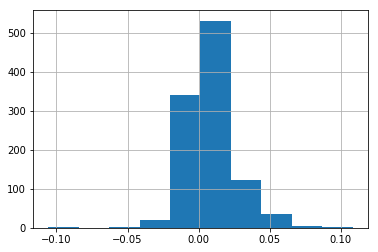

In [37]:
combined_with_changes["relative_payment_change"].hist()

In [38]:
combined_with_changes.sort_values(by="relative_payment_change").head(10)

,,VName,FYEAR,Payment,Enrollment,FTE Count,Education spending,payment_pct,fte_per_student,spending_per_student,payment_per_student,staffing_change_pct,payment_change_dollars,payment_change_pct,payment_change_per_student,relative_payment_change
City,report_year,,,,,,,,,,,,,,,
NEW BRITAIN,2012,New Britain,2012,9.990252e+07,11011.87,1362.0,132786000.0,0.752357,0.123685,12058.442390,9072.257493,0.004055,-14044987.54,-0.123258,-1275.440733,-0.105772
HAMDEN,2016,Hamden,2016,3.534831e+07,6434.02,1055.8,94446338.0,0.374269,0.164096,14679.211131,5493.969455,-0.003774,-4728864.94,-0.117994,-734.978278,-0.050069
NEW HAVEN,2012,New Haven,2012,2.387311e+08,18002.23,3178.5,203686746.0,1.172050,0.176561,11314.528589,13261.197076,-0.029584,-9251305.45,-0.037306,-513.897748,-0.045419
NEWINGTON,2011,Newington,2011,1.508820e+07,4500.94,648.4,64499000.0,0.233929,0.144059,14330.117709,3352.232498,-0.005674,-2832411.96,-0.158053,-629.293428,-0.043914
BRISTOL,2011,Bristol,2011,5.402968e+07,8760.05,1218.6,96785000.0,0.558244,0.139109,11048.452920,6167.736442,-0.015909,-3795229.86,-0.065633,-433.242945,-0.039213
BOZRAH,2011,Bozrah,2011,1.517070e+06,356.91,44.2,5546367.0,0.273525,0.123841,15539.959654,4250.566333,-0.057569,-196120.30,-0.114477,-549.495111,-0.035360
WATERBURY,2012,Waterbury,2012,1.724756e+08,17533.14,2805.2,175180000.0,0.984562,0.159994,9991.364924,9837.120879,0.089313,-5419596.39,-0.030465,-309.105864,-0.030937
BOLTON,2011,Bolton,2011,3.751773e+06,829.15,155.9,13011924.0,0.288333,0.188024,15693.088102,4524.842839,-0.040025,-401893.48,-0.096756,-484.705397,-0.030887
STERLING,2013,Sterling,2013,3.823159e+06,664.02,178.1,8274645.0,0.462033,0.268215,12461.439414,5757.595976,1.037757,-249116.06,-0.061174,-375.163489,-0.030106


In [39]:
# combined_with_changes.sort_values(by="relative_payment_change",ascending=False).head(10)
combined_with_changes[combined_with_changes["relative_payment_change"] > 0.05].sort_values(by="relative_payment_change",ascending=False)

VName  FYEAR       Payment  Enrollment  \
City        report_year                                                 
NEW HAVEN   2013           New Haven   2013  2.609013e+08    18412.50   
WATERBURY   2010           Waterbury   2010  1.769034e+08    17623.54   
NORWICH     2013             Norwich   2013  5.199528e+07     5412.87   
NEW HAVEN   2016           New Haven   2016  2.923954e+08    19066.83   
NEW LONDON  2014          New London   2014  4.224478e+07     3532.73   
NEW BRITAIN 2013         New Britain   2013  1.090775e+08    11186.16   
BRIDGEPORT  2015          Bridgeport   2015  2.828339e+08    21095.81   
HARTFORD    2013            Hartford   2013  3.333122e+08    21656.00   
            2015            Hartford   2015  3.605252e+08    21596.84   
BRIDGEPORT  2008          Bridgeport   2008  2.258585e+08    21801.84   
NEW HAVEN   2010           New Haven   2010  2.430286e+08    17704.41   
HARTFORD    2007            Hartford   2007  2.728441e+08    22408.12   
WATERBURY   2014           Waterbury   2014  1.875164e+08    17970.40   
NEW BRITAIN 2010         New Britain   2010  1.095078e+08    10873.74   
HARTFORD    2010            Hartford   2010  3.074405e+08    21318.38   
NEW LONDON  2015          New London   2015  4.477632e+07     3594.91   
NEW BRITAIN 2008         New Britain   2008  9.929949e+07    10984.91   
BRIDGEPORT  2013          Bridgeport   2013  2.544349e+08    20484.53   
NEW HAVEN   2008           New Haven   2008  2.215514e+08    18546.95   
WEST HAVEN  2009          West Haven   2009  5.495661e+07     7335.32   
BRIDGEPORT  2016          Bridgeport   2016  2.970365e+08    20945.51   
EASTFORD    2008            Eastford   2008  1.308353e+06      268.55   
DERBY       2015               Derby   2015  1.096509e+07     1587.76   
NEW HAVEN   2014           New Haven   2014  2.715365e+08    18738.35   
WATERBURY   2008           Waterbury   2008  1.512617e+08    17776.39   
NORWICH     2008             Norwich   2008  4.488497e+07     5590.52   

                         FTE Count  Education spending  payment_pct  \
City        report_year                                               
NEW HAVEN   2013            3105.7         204422059.0     1.276287   
WATERBURY   2010            2838.5         169827000.0     1.041668   
NORWICH     2013             662.3          75394000.0     0.689647   
NEW HAVEN   2016            3235.2         214734762.0     1.361659   
NEW LONDON  2014             473.8          45031924.0     0.938107   
NEW BRITAIN 2013            1379.4         133504000.0     0.817035   
BRIDGEPORT  2015            2969.0         264104051.0     1.070918   
HARTFORD    2013            3284.0         314620000.0     1.059412   
            2015            3505.3         326647000.0     1.103715   
BRIDGEPORT  2008            2910.5         218222813.0     1.034990   
NEW HAVEN   2010            3154.4         194071482.0     1.252263   
HARTFORD    2007            3803.9         279086000.0     0.977635   
WATERBURY   2014            2876.2         180634000.0     1.038101   
NEW BRITAIN 2010            1381.6         120254000.0     0.910637   
HARTFORD    2010            3174.0         305210000.0     1.007308   
NEW LONDON  2015             511.6          45127644.0     0.992215   
NEW BRITAIN 2008            1357.0         160456000.0     0.618858   
BRIDGEPORT  2013            2811.1         261470234.0     0.973093   
NEW HAVEN   2008            3160.1         256210171.0     0.864725   
WEST HAVEN  2009             985.2          78628886.0     0.698937   
BRIDGEPORT  2016            3157.9         273774169.0     1.084969   
EASTFORD    2008              31.2           3519454.0     0.371749   
DERBY       2015             256.3          22108184.0     0.495974   
NEW HAVEN   2014            4053.4         210739315.0     1.288495   
WATERBURY   2008            2819.7         218774000.0     0.691406   
NORWICH     2008             703.2          79020000.0     0.568020  

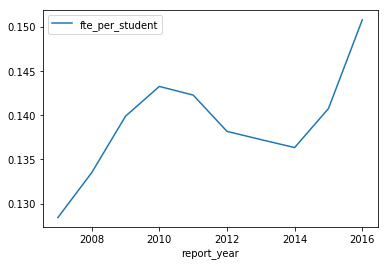

In [40]:
def plot_vars(city):
    
    df = combined_with_changes.loc[city]
    df[["fte_per_student"]].plot()

plot_vars("BRIDGEPORT")

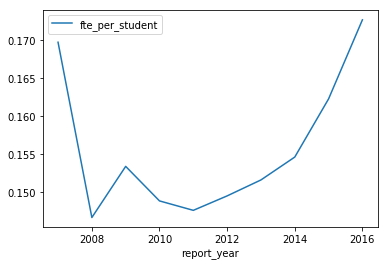

In [41]:
plot_vars("HARTFORD")